In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

import optical_bloch
from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

from optical_bloch.julia_utils import (
    OdeParameters,
    init_julia,
    OBEProblem,
    OBEProblemConfig,
    setup_solve_problem,
    init_julia_ensemble,
    OBEEnsembleProblem,
    OBEEnsembleProblemConfig,
    solve_problem_ensemble,
    setup_ensemble_problem,
    get_diagonal_indices_flattened,
)

plt.rcParams.update({"font.size": 14})

c:\Users\ogras\anaconda3\envs\optical-bloch-python\Lib\site-packages\juliacall\__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# 4 ground states, 3 excited states (i.e. F=0, F=1 to F=1 excited)

ω = smp.Symbol("ω", real=True)
Ωz = smp.Symbol("Ωz", complex=True)
Ωx = smp.Symbol("Ωx", complex=True)
δ = smp.Symbol("δ", real=True)

ham = Hamiltonian(7)

# Z polarization
ham.add_manifold_coupling(
    [0, 1, 3],
    [5, 4, 6],
    Ωz,
    ω,
)

# X polarization
ham.add_manifold_coupling([0, 0, 1, 2, 2, 3], [4, 6, 5, 4, 6, 5], Ωx, ω)

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 5, δ)
ham.remove_common_energy()

display(ham.transformed)

Matrix([
[                              E0,                                0,                                0,                                0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                               E1,                                0,                                0, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2,                    0],
[                               0,                                0,                               E2,                                0, -Ωx*exp(1.0*I*t*ω)/2,                    0, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                                0,                                0,                               E3,                    0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2],
[-exp(-1.0*I*t*ω)*conjugate(Ωx)/2, -exp(-1.0*I*t*ω)*conjugate(Ωz)/2, -exp(-1.0*I*t*ω)*conjugate(Ωx)/2,                                0,                   E4,                 

Matrix([
[          E0 + ω,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,           E1 + ω,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,           E2 + ω,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,           E3 + ω,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,    E4,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,    E5,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,    E6]])

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [3]:
ham.detunings

[[ω, E0, E5, δ, 0, 5]]

In [4]:
ham.eqn_transform_graph()
display(ham.transformed)

ham._replace_with_detunings()

ham.remove_common_energy()

display(ham.transformed)


Matrix([
[          E0 + ω,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,           E1 + ω,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,           E2 + ω,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,           E3 + ω,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,    E4,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,    E5,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,    E6]])

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [5]:
Γ = smp.Symbol("Γ", real=True)
dis = Dissipator(ham.levels)

for idi, idf in zip([4, 4, 4, 5, 5, 5, 6, 6, 6], [0, 1, 2, 0, 1, 3, 0, 2, 3]):
    dis.add_decay(idi, idf, Γ)

display(dis.dissipator)


Matrix([
[Γ*(ρ44(t) + ρ55(t) + ρ66(t)),                        0,                        0,                        0,          -3*Γ*ρ04(t)/2,          -3*Γ*ρ05(t)/2, -3*Γ*ρ06(t)/2],
[                           0,      Γ*(ρ44(t) + ρ55(t)),                        0,                        0,          -3*Γ*ρ14(t)/2,          -3*Γ*ρ15(t)/2, -3*Γ*ρ16(t)/2],
[                           0,                        0,      Γ*(ρ44(t) + ρ66(t)),                        0,          -3*Γ*ρ24(t)/2,          -3*Γ*ρ25(t)/2, -3*Γ*ρ26(t)/2],
[                           0,                        0,                        0,      Γ*(ρ55(t) + ρ66(t)),          -3*Γ*ρ34(t)/2,          -3*Γ*ρ35(t)/2, -3*Γ*ρ36(t)/2],
[    -3*Γ*conjugate(ρ04(t))/2, -3*Γ*conjugate(ρ14(t))/2, -3*Γ*conjugate(ρ24(t))/2, -3*Γ*conjugate(ρ34(t))/2,            -3*Γ*ρ44(t),            -3*Γ*ρ45(t),   -3*Γ*ρ46(t)],
[    -3*Γ*conjugate(ρ05(t))/2, -3*Γ*conjugate(ρ15(t))/2, -3*Γ*conjugate(ρ25(t))/2, -3*Γ*conjugate(ρ35(t))/2, -3*Γ*conjugate(ρ4

In [6]:
E0, E1, E2, E3, E4, E5, E6 = ham.energies
replacements = [(E2, E1), (E3, E1), (E4, E2), (E5, E2), (E6, E2)]
transformed = ham.transformed.copy()
transformed = transformed.subs(replacements)

In [7]:
display(transformed)

Matrix([
[              -δ,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,     -E0 + E1 - δ,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,     -E0 + E1 - δ,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,     0,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,     0,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,     0]])

In [8]:
bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [9]:
replacements = [
    (Ωx, "Ω0*resonant_switching(t, ωpol, 0.0)"),
    (Ωz, "Ω0*resonant_switching(t, ωpol, 3.1415)"),
    (E0, 0),
    (E1, 0.1),
]

code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements
    )
)

In [10]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ = p[1]
		Ω0 = p[2]
		δ = p[3]
		ωpol = p[4]
		E0 = 0
		E1 = 0.1
		Ωx = Ω0*resonant_switching(t, ωpol, 0.0)
		Ωz = Ω0*resonant_switching(t, ωpol, 3.1415)
		du[1,1] = Γ*(u[5,5] + u[6,6] + u[7,7]) + 1.0im*(Ωx*conj(u[1,5]) + Ωx*conj(u[1,7]) + Ωz*conj(u[1,6]) - u[1,5]*conj(Ωx) - u[1,6]*conj(Ωz) - u[1,7]*conj(Ωx))/2
		du[1,2] = 1.0im*(-E0*u[1,2] + E1*u[1,2] + Ωx*conj(u[2,5])/2 + Ωx*conj(u[2,7])/2 + Ωz*conj(u[2,6])/2 - u[1,5]*conj(Ωz)/2 - u[1,6]*conj(Ωx)/2)
		du[1,3] = 1.0im*(-E0*u[1,3] + E1*u[1,3] + Ωx*conj(u[3,5])/2 + Ωx*conj(u[3,7])/2 + Ωz*conj(u[3,6])/2 - u[1,5]*conj(Ωx)/2 - u[1,7]*conj(Ωx)/2)
		du[1,4] = 1.0im*(-E0*u[1,4] + E1*u[1,4] + Ωx*conj(u[4,5])/2 + Ωx*conj(u[4,7])/2 + Ωz*conj(u[4,6])/2 - u[1,6]*conj(Ωx)/2 - u[1,7]*conj(Ωz)/2)
		du[1,5] = -3*Γ*u[1,5]/2 + 1.0im*(-Ωx*u[1,1] - Ωx*u[1,3] + Ωx*u[5,5] + Ωx*conj(u[5,7]) - Ωz*u[1,2] + Ωz*conj(u[5,6]) + 2*δ*u[1,5])/2
		du[1,6] = -3*Γ*u[1,6]/2 + 1.0im*(-Ωx*u[1,2] - Ωx*u[1,4] + Ωx*u

In [11]:
odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)
odepars

odepars.Ω0 = 1.0
odepars.Γ = 1.0
odepars.δ = 0.0
odepars.ωpol = 0.5

In [12]:
odepars

OdeParameters(Γ=1.0, Ω0=1.0, δ=0.0, ωpol=0.5)

In [13]:
odepars.parameter_values

{Ωx: Ω0*resonant_switching(t, ωpol, 0.0),
 Ωz: Ω0*resonant_switching(t, ωpol, 3.1415),
 E0: 0,
 E1: 0.1,
 Γ: 1.0,
 Ω0: 1.0,
 δ: 0.0,
 ωpol: 0.5}

In [14]:
from juliacall import Main as jl

init_julia(code)

In [16]:
ρ = np.zeros(transformed.shape, dtype=complex)
for idx in range(4):
    ρ[idx, idx] = 1 / 4

problem = OBEProblem(odepars, ρ, (0, 150))
config = OBEProblemConfig(save_everystep=True)

In [17]:
sol = setup_solve_problem(problem, config)

15.55


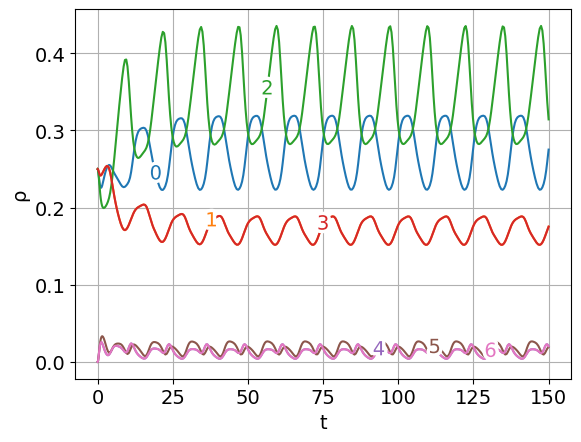

In [18]:
from labellines import labelLines

t = sol.t
y = np.einsum("ijj -> ij", sol.y).real

fig, ax = plt.subplots()
ax.plot(t, y, label=np.arange(ham.levels))

ax.set_xlabel("t")
ax.set_ylabel("population")

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.grid()

print(f"{np.trapezoid(y[:, -3:].sum(axis=1)):.2f}")

In [19]:
ti = np.linspace(0, 100, 101)

resx = odepars.time_evolution_parameter("Ωx", ti)
resz = odepars.time_evolution_parameter("Ωz", ti)

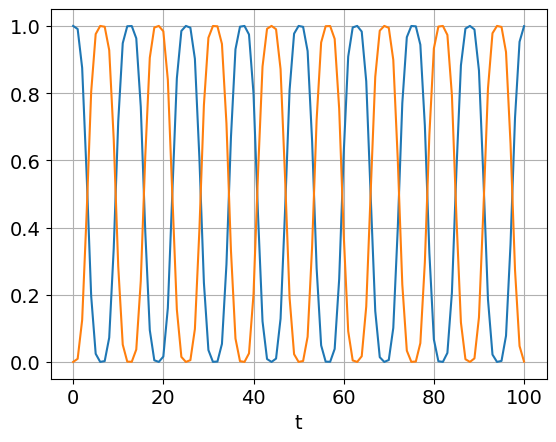

In [20]:
fig, ax = plt.subplots()
ax.plot(ti, resx)
ax.plot(ti, resz)

ax.set_xlabel("t")

ax.grid()

# Parallel Simulation

In [21]:
init_julia_ensemble(lindblad_function=code, nprocs=6)

In [32]:
# can scan over the parameters below
odepars


OdeParameters(Γ=1.0, Ω0=1.0, δ=0.0, ωpol=0.5)

In [48]:
ensemble_problem = OBEEnsembleProblem(
    problem,
    ["Ω0"],
    [np.linspace(0, 2.0, 11)],
    combinations=False,
)

# only saving the state populations for the excited states
ensemble_config = OBEEnsembleProblemConfig(
    save_everystep=False,
    save_idxs=get_diagonal_indices_flattened(ham.levels, [4, 5, 6], mode="julia"),
    saveat=0.1,
)

setup_ensemble_problem(odepars, ensemble_problem)


In [49]:
solve_problem_ensemble(ensemble_problem, ensemble_config)

In [50]:
# getting the solutions as numpy arrays requires some conversion an list comprehension
# here we loop over the number of trajectories, given by range(1, len(jl.sol) + 1)
# and over the timesteps range(len(jl.sol[idx].u))
# for some reason looping over the trajectories starts at 1, but looping over the
# timesteps starts at 0, probably because jl.sol[idx].u converts to a python object and
# then the indexing starts at 0
res = [
    np.array([np.array(jl.sol[idx].u[idu]).real for idu in range(len(jl.sol[idx].u))])
    for idx in range(1, len(jl.sol) + 1)
]
t = [np.array(jl.sol[idx].t) for idx in range(1, len(jl.sol) + 1)]


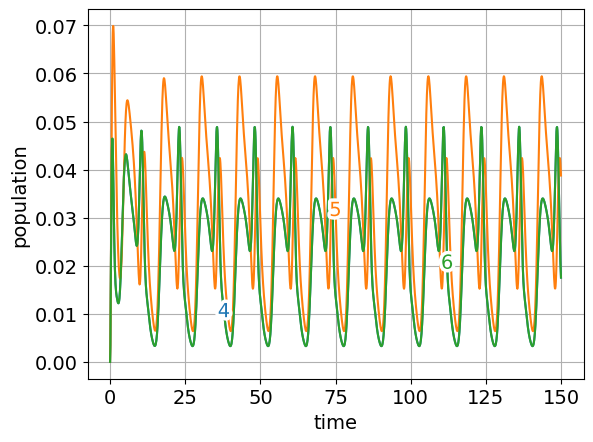

In [51]:
idx = 9

fig, ax = plt.subplots()

ax.plot(t[idx], np.squeeze(res[idx]), label=[4, 5, 6])

ax.set_xlabel("time")
ax.set_ylabel("population")

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.grid()


now integrating the excited state to get the # photons

In [41]:
jl.seval("@everywhere using Trapz")
jl.seval("""
@everywhere function output_func(sol, i)
    trapz(sol.t, [real(sum(sol.u[j])) for j in 1:size(sol)[2]]), false
end
""")


In [102]:
jl.seval("vec(real(sum(vcat(sol[1].u...), dims=2)))")

1501-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [105]:
jl.seval("trapz(vec(rand(10,5)))")

JuliaError: MethodError: no method matching trapz(::Vector{Float64})

Closest candidates are:
  trapz(::Any, !Matched::Any)
   @ Trapz C:\Users\ogras\.julia\packages\Trapz\UoNri\src\Trapz.jl:6
  trapz(::Any, !Matched::Any, !Matched::Val{i}) where i
   @ Trapz C:\Users\ogras\.julia\packages\Trapz\UoNri\src\Trapz.jl:10

Stacktrace:
 [1] top-level scope
   @ none:1
 [2] eval
   @ .\boot.jl:385 [inlined]
 [3] eval
   @ .\Base.jl:88 [inlined]
 [4] pyjlmodule_seval(self::Module, expr::Py)
   @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\module.jl:13
 [5] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
   @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\base.jl:66
 [6] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
   @ PythonCall.JlWrap.Cjl C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\C.jl:63

In [99]:
jl.seval("trapz(vec(real(sum(vcat(sol[1].u...), dims=2))))")

JuliaError: MethodError: no method matching trapz(::Vector{Float64})

Closest candidates are:
  trapz(::Any, !Matched::Any)
   @ Trapz C:\Users\ogras\.julia\packages\Trapz\UoNri\src\Trapz.jl:6
  trapz(::Any, !Matched::Any, !Matched::Val{i}) where i
   @ Trapz C:\Users\ogras\.julia\packages\Trapz\UoNri\src\Trapz.jl:10

Stacktrace:
 [1] top-level scope
   @ none:1
 [2] eval
   @ .\boot.jl:385 [inlined]
 [3] eval
   @ .\Base.jl:88 [inlined]
 [4] pyjlmodule_seval(self::Module, expr::Py)
   @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\module.jl:13
 [5] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
   @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\base.jl:66
 [6] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
   @ PythonCall.JlWrap.Cjl C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\C.jl:63

In [46]:
ensemble_problem = OBEEnsembleProblem(
    problem,
    ["Ω0"],
    [np.linspace(0, 2.0, 11)],
    output_func="output_func",
    combinations=False,
)

# only saving the state populations for the excited states
ensemble_config = OBEEnsembleProblemConfig(
    save_everystep=False,
    save_idxs=get_diagonal_indices_flattened(ham.levels, [4, 5, 6], mode="julia"),
    saveat=0.1,
)

setup_ensemble_problem(odepars, ensemble_problem)


In [47]:
solve_problem_ensemble(ensemble_problem, ensemble_config)

JuliaError: On worker 2:
AssertionError: Integration axis over `y` is incompatible with `x`. Make sure their length match!
Stacktrace:
  [1] integrate
    @ C:\Users\ogras\.julia\packages\Trapz\UoNri\src\kernels.jl:23 [inlined]
  [2] integrate
    @ C:\Users\ogras\.julia\packages\Trapz\UoNri\src\kernels.jl:64 [inlined]
  [3] trapz
    @ C:\Users\ogras\.julia\packages\Trapz\UoNri\src\Trapz.jl:7
  [4] output_func
    @ .\none:2
  [5] #batch_func#607
    @ C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:193
  [6] batch_func
    @ C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:180 [inlined]
  [7] #609
    @ C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:230 [inlined]
  [8] #exec_from_cache#213
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\workerpool.jl:357
  [9] exec_from_cache
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\workerpool.jl:355
 [10] #invokelatest#2
    @ .\essentials.jl:892
 [11] invokelatest
    @ .\essentials.jl:889
 [12] #110
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:287
 [13] run_work_thunk
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:70
 [14] #109
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:287
Stacktrace:
  [1] (::Base.var"#1033#1035")(x::Task)
    @ Base .\asyncmap.jl:171
  [2] foreach(f::Base.var"#1033#1035", itr::Vector{Any})
    @ Base .\abstractarray.jl:3097
  [3] maptwice(wrapped_f::Function, chnl::Channel{Any}, worker_tasks::Vector{Any}, c::UnitRange{Int64})
    @ Base .\asyncmap.jl:171
  [4] wrap_n_exec_twice
    @ .\asyncmap.jl:147 [inlined]
  [5] #async_usemap#1018
    @ .\asyncmap.jl:97 [inlined]
  [6] async_usemap
    @ .\asyncmap.jl:78 [inlined]
  [7] #asyncmap#1017
    @ .\asyncmap.jl:75 [inlined]
  [8] asyncmap
    @ .\asyncmap.jl:74 [inlined]
  [9] pmap(f::Function, p::CachingPool, c::UnitRange{Int64}; distributed::Bool, batch_size::Int64, on_error::Nothing, retry_delays::Vector{Any}, retry_check::Nothing)
    @ Distributed C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\pmap.jl:126
 [10] pmap
    @ C:\Users\ogras\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\pmap.jl:99 [inlined]
 [11] solve_batch(prob::EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Int64, Int64}, true, NTuple{4, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lindblad!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, @Kwargs{}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, alg::Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, ensemblealg::EnsembleDistributed, II::UnitRange{Int64}, pmap_batch_size::Int64; kwargs::@Kwargs{abstol::Float64, reltol::Float64, dt::Float64, save_everystep::Bool, saveat::Float64, save_idxs::Matrix{Int64}, save_start::Bool})
    @ SciMLBase C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:229
 [12] solve_batch
    @ C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:217 [inlined]
 [13] macro expansion
    @ .\timing.jl:395 [inlined]
 [14] (::SciMLBase.var"#605#606"{Int64, Int64, Int64, @Kwargs{abstol::Float64, reltol::Float64, dt::Float64, save_everystep::Bool, saveat::Float64, save_idxs::Matrix{Int64}, save_start::Bool}, EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Int64, Int64}, true, NTuple{4, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lindblad!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, @Kwargs{}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, EnsembleDistributed})()
    @ SciMLBase C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:146
 [15] with_logstate(f::Function, logstate::Any)
    @ Base.CoreLogging .\logging.jl:515
 [16] with_logger
    @ .\logging.jl:627 [inlined]
 [17] __solve(prob::EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Int64, Int64}, true, NTuple{4, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lindblad!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, @Kwargs{}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, alg::Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, ensemblealg::EnsembleDistributed; trajectories::Int64, batch_size::Int64, progress_aggregate::Bool, pmap_batch_size::Int64, kwargs::@Kwargs{abstol::Float64, reltol::Float64, dt::Float64, save_everystep::Bool, saveat::Float64, save_idxs::Matrix{Int64}, save_start::Bool})
    @ SciMLBase C:\Users\ogras\.julia\packages\SciMLBase\sakPO\src\ensemble\basic_ensemble_solve.jl:130
 [18] #solve#55
    @ C:\Users\ogras\.julia\packages\DiffEqBase\DS1sd\src\solve.jl:1096 [inlined]
 [19] top-level scope
    @ none:1
 [20] eval
    @ .\boot.jl:385 [inlined]
 [21] eval
    @ .\Base.jl:88 [inlined]
 [22] pyjlmodule_seval(self::Module, expr::Py)
    @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\module.jl:13
 [23] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
    @ PythonCall.JlWrap C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\base.jl:66
 [24] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
    @ PythonCall.JlWrap.Cjl C:\Users\ogras\.julia\packages\PythonCall\S5MOg\src\JlWrap\C.jl:63